In [21]:
# required imports
from nltk.classify import accuracy, NaiveBayesClassifier
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction import text 
from textblob import TextBlob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import time


In [13]:
# vector is defined according to features identified 
# over the tfm document

global_features = {}

# origin type
global_features['origin'] = []
# joy
global_features['origin'].append('pleasant')
global_features['origin'].append('wellness')
# sadness
global_features['origin'].append('setback')
# anger
global_features['origin'].append('frustration')
global_features['origin'].append('adversity')
# fear
global_features['origin'].append('danger')
# surprise
global_features['origin'].append('stimulus')
global_features['origin'].append('unexpected')
global_features['origin'].append('intensity')


# effect type
global_features['effect'] = []

# consequence type
global_features['consequence'] = []
# joy
global_features['consequence'].append('smile')
global_features['consequence'].append('interaction')
global_features['consequence'].append('creativity')
# sadness
global_features['consequence'].append('refusal')
global_features['consequence'].append('misfortune')
global_features['consequence'].append('weakness')
# anger
global_features['consequence'].append('destroy')
global_features['consequence'].append('aggressiveness')
global_features['consequence'].append('hostile')
# fear
global_features['consequence'].append('obsession')
global_features['consequence'].append('panic')
global_features['consequence'].append('phobia')
global_features['consequence'].append('anxiety')
# surprise
global_features['consequence'].append('setback')

In [14]:
# some common functions 

# used to avoid accessing the global features var directly
def get_features():
    return global_features

# used to remove stopwords from a phrase
def get_clean_phrase(phrase):
    return ' '.join(word for (word) in phrase.split() if word not in text.ENGLISH_STOP_WORDS)

In [15]:
# functions to generate vectors and calculate scores

def generate_vector_v1(phrase):
    vector = {}
    value = 0
    features = get_features()
    for feature_type, feature_names in features.items():
        for feature_name in feature_names:
            key = "{}({})".format(feature_type, feature_name)
            feature_data = {}
            value = get_similarity_score_v1(feature_name, phrase)
            feature_data[key] = value
            vector.update(feature_data)
    return vector


# similarity is calculated as avg of all similarities
# absolute value, rounded to 2 decimals
# s = (sim_w1 + sim_w1 + ... + sim_wn)/n
# if any word has none similarity, it will be counted as 0
def get_similarity_score_v1(feature, phrase):
    feature_synsets = wn.synsets(feature)
    # we use the first definition
    feature_synset = feature_synsets[0]
    score = 0
    word_counter = 0
    for (word) in phrase.split():
        phrase_word_synsets = wn.synsets(word)
        if (len(phrase_word_synsets) > 0):
            cur = feature_synset.wup_similarity(phrase_word_synsets[0])
            cur = 0 if cur is None else cur
        else:
            cur = 0
        score += cur
        word_counter += 1
    score = round(score, 2)
    return score

In [16]:

# sample vector generation

# obtain a phrase
sample_phrases = []
sample_phrases.append("i honestly do not feel discouraged today as i usually do")
sample_phrases.append("i feel energetic and excited to see my results at the end of the week")
sample_phrases.append("i cant help to also feel a little restless")
sample_phrases.append("felt anger when at the end of telephone call")



# we iterate over phrases
for sample_phrase in sample_phrases:
    print(sample_phrase)    
    sample_phrase_clean = get_clean_phrase(sample_phrase)
    print(sample_phrase_clean)
    sample_vector = generate_vector_v1(sample_phrase_clean)
    print(sample_vector)
    print("\n")

i honestly do not feel discouraged today as i usually do
honestly feel discouraged today usually
{'origin(pleasant)': 0, 'origin(wellness)': 0.59, 'origin(setback)': 0.73, 'origin(frustration)': 0.55, 'origin(adversity)': 0.66, 'origin(danger)': 0.77, 'origin(stimulus)': 0.87, 'origin(unexpected)': 0, 'origin(intensity)': 0.77, 'consequence(smile)': 0.56, 'consequence(interaction)': 0.68, 'consequence(creativity)': 0.87, 'consequence(refusal)': 0.64, 'consequence(misfortune)': 0.68, 'consequence(weakness)': 0.77, 'consequence(destroy)': 1.4, 'consequence(aggressiveness)': 0.77, 'consequence(hostile)': 0.52, 'consequence(obsession)': 0.73, 'consequence(panic)': 0.66, 'consequence(phobia)': 0.59, 'consequence(anxiety)': 0.71, 'consequence(setback)': 0.73}


i feel energetic and excited to see my results at the end of the week
feel energetic excited results end week
{'origin(pleasant)': 0, 'origin(wellness)': 0.71, 'origin(setback)': 1.07, 'origin(frustration)': 0.67, 'origin(adversity)':

In [17]:
# dataset is loaded into different dataframes
df_test = pd.read_csv("data/test.txt", sep=";", names=['phrase', 'feeling'])
df_train = pd.read_csv("data/train.txt", sep=";", names=['phrase', 'feeling'])
df_val = pd.read_csv("data/val.txt", sep=";", names=['phrase', 'feeling'])

# dataframes are joined
df = pd.concat([df_test, df_train, df_val])


# remove "love" feeling as we do not have features for it
data_without_love = df[df['feeling']!= 'love'] 

# we print the phrase count for each feeling
print(data_without_love.groupby(['feeling']).agg(['count']))


         phrase
          count
feeling        
anger      2709
fear       2373
joy        6761
sadness    5797
surprise    719


In [18]:

# since the min amount of phrases is 719 for one feeling
# we create a subset to avoid overtraining
# and by doing this, we balance the dataset
data_filtered = pd.concat([data_without_love[data_without_love['feeling']== 'anger'].sample(720), \
                          data_without_love[data_without_love['feeling']== 'fear'].sample(720), \
                          data_without_love[data_without_love['feeling']== 'joy'].sample(720), 
                          data_without_love[data_without_love['feeling']== 'sadness'].sample(720),
                          data_without_love[data_without_love['feeling']== 'surprise']])
    
#data_filtered = data_without_love
print(data_filtered.groupby(['feeling']).agg(['count']))

         phrase
          count
feeling        
anger       720
fear        720
joy         720
sadness     720
surprise    719


In [19]:
# features are extracted

all_vectors = []

# used to measure time used by exctraction process
tic = time.perf_counter()
    
for index, row in data_filtered.iterrows():
    phrase = row['phrase']
    feeling = row['feeling']
    #print(phrase)
    phrase_clean = get_clean_phrase(phrase)
    vector = generate_vector_v1(phrase_clean)
    all_vectors.append((vector, feeling))


toc = time.perf_counter()

print(f"Features extracted in {toc - tic:0.2f} seconds")
print("\n")

# two random vectors are printed to validate
random.shuffle(all_vectors)
for vector in all_vectors[0:2]:
    print(vector)
    print("\n")

print("Total vectors obtained: ")
print(len(all_vectors))

Features extracted in 197.52 seconds


({'origin(pleasant)': 0, 'origin(wellness)': 2.56, 'origin(setback)': 1.63, 'origin(frustration)': 1.98, 'origin(adversity)': 2.45, 'origin(danger)': 2.71, 'origin(stimulus)': 1.77, 'origin(unexpected)': 0, 'origin(intensity)': 2.12, 'consequence(smile)': 1.39, 'consequence(interaction)': 1.52, 'consequence(creativity)': 1.77, 'consequence(refusal)': 1.42, 'consequence(misfortune)': 1.52, 'consequence(weakness)': 2.57, 'consequence(destroy)': 2.09, 'consequence(aggressiveness)': 2.12, 'consequence(hostile)': 1.3, 'consequence(obsession)': 1.63, 'consequence(panic)': 2.38, 'consequence(phobia)': 2.07, 'consequence(anxiety)': 2.52, 'consequence(setback)': 1.63}, 'sadness')


({'origin(pleasant)': 0, 'origin(wellness)': 1.59, 'origin(setback)': 1.82, 'origin(frustration)': 1.63, 'origin(adversity)': 1.8, 'origin(danger)': 2.07, 'origin(stimulus)': 1.81, 'origin(unexpected)': 0, 'origin(intensity)': 1.75, 'consequence(smile)': 1.33, 'consequence(inter

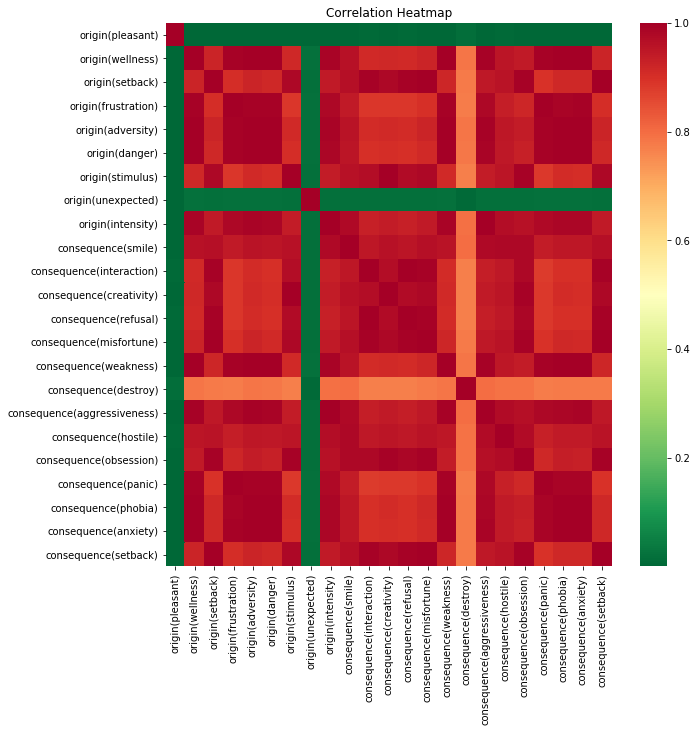

In [22]:
# correlation matrix is obtained

# to get vals from vectors
def get_vals(dicti):
    tot = []
    for test in dicti:
        ar = []
        for k, v in test.items():
            ar.append(v)
        tot.append(ar)
    return tot

# to get vals from vectors
def get_col_names(dicti):
    ar = []
    for k, v in dicti[0].items():
        ar.append(k)
    return ar

data = [vector for (vector, emotion) in all_vectors]
value_data = get_vals(data)
values_dataframe = pd.DataFrame(data=value_data, columns=get_col_names(data))

value_correlation = values_dataframe.corr().abs()

# first an initial heatmap to visulize correlation
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(value_correlation, cmap='RdYlGn_r')
plt.title('Correlation Heatmap')
plt.show()



In [23]:
# selecting features (columns) with correlation under 0.4 

correlation_threshold = 0.4

not_correlated =~(value_correlation.mask(np.tril(np.ones([len(value_correlation)]*2, dtype=bool))).abs() > correlation_threshold).any()
uncorrlenated_columns = not_correlated.loc[not_correlated[not_correlated.index] == True].index
print(uncorrlenated_columns)
print(len(uncorrlenated_columns))



Index(['origin(pleasant)', 'origin(wellness)', 'origin(unexpected)'], dtype='object')
3
